In [94]:
import datetime

import numpy as np
import pandas as pd
import gudhi

from traffic.core import Traffic, Flight
from functions.data_filtering import ICAO_codes, large_gap_filter
from functions.data_processing import flight_pers, remove_outliers_z_score, remove_outliers_dbscan
from functions.data_loading import linkage_cluster_persistances, flights_from_query

from scipy.cluster.hierarchy import fcluster

seed = 210401

In [95]:
# The flights can be converted into a Traffic object
count = 500
with_GA_flights = flights_from_query(None, count, "data/with_GA_flights.pkl")
without_GA_flights = flights_from_query(None, count, "data/without_GA_flights.pkl")

In [96]:
with_GA_flights = list(filter(large_gap_filter, with_GA_flights))
without_GA_flights = list(filter(large_gap_filter, without_GA_flights))

with_GA_labels = np.ones(len(with_GA_flights))
without_GA_labels = np.zeros(len(without_GA_flights))

flights = with_GA_flights + without_GA_flights
labels = np.concatenate((with_GA_labels, without_GA_labels))

trees, paths = flight_pers(flights)

100%|██████████| 1389/1389 [00:36<00:00, 38.35it/s]


In [97]:
from gudhi.representations import Landscape

resolution = 15
n_landscapes = 3
landscape = Landscape(resolution=resolution, num_landscapes=n_landscapes)
landscapes = []

for i in trees:
    landscapes.append(landscape.fit_transform([i.persistence_intervals_in_dimension(1)]))
landscapes = np.array(landscapes)

landscapes = landscapes.reshape(landscapes.shape[0], landscapes.shape[2])

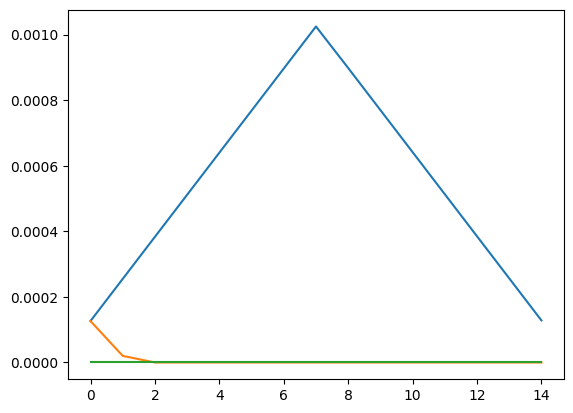

In [98]:
from matplotlib import pyplot as plt

diagram = 6
for i in range(n_landscapes):
    plt.plot(landscapes[diagram][i*resolution:(i+1)*resolution])

In [99]:
from sklearn.model_selection import train_test_split

x_train, x_test_val, y_train, y_test_val = train_test_split(landscapes, labels, test_size=0.3, random_state=seed)
x_test, x_val, y_test, y_val = train_test_split(x_test_val, y_test_val, test_size=0.5, random_state=seed)

In [100]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn import tree
from sklearn import svm

models = {
    "Decition Tree" : [tree.DecisionTreeClassifier(random_state=seed), {
        "min_samples_leaf" : [2, 3],
        "min_samples_split" : [2, 3]
    }],
    "Support Vector Machines" : [svm.SVC(random_state=seed), {
        "C" : [1, 2, 3], 
        "break_ties": [True, False], 
        "probability": [True, False]
    }],
    "Base line" : [DummyClassifier(strategy = "most_frequent"), {
        
    }],
    "Multi-layer Perception" : [MLPClassifier(random_state=seed, max_iter = 5000), {
        "hidden_layer_sizes" : [10, 20, 30], 
        
    }],
    "K Nearest Neighbors" : [KNeighborsClassifier(), {
        "n_neighbors" : [5, 10, 20, 40], 
        "p": [1, 2, 3]
    }],
    "Random Forrest Regressor" : [RandomForestClassifier(random_state=seed), {
        "max_depth": [2, 3], 
        "n_estimators" : [50, 100, 300]
    }],
    "Decision Tree Regressor" : [DecisionTreeClassifier(random_state=seed), {
        "min_samples_split" : [2, 3, 4],
        "min_samples_leaf" : [1, 2, 3]
    }],
}

In [101]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV

datalist = []

for i in models.keys():
    #does the gridsearch on the models
    model = GridSearchCV(models[i][0], models[i][1])
    #makes a prediction
    prediction = model.fit(x_train, y_train).predict(x_test)
    #finds out how good that prediction is
    
    balanced_accuracy = balanced_accuracy_score(y_test, prediction)
    datalist.append([model.best_estimator_, balanced_accuracy])

In [102]:
for i, j in datalist:
    print(f"{i.__repr__(): <70}: {j: .3}")

DecisionTreeClassifier(min_samples_leaf=3, random_state=210401)       :  0.909
SVC(C=3, break_ties=True, probability=True, random_state=210401)      :  0.94
DummyClassifier(strategy='most_frequent')                             :  0.5
MLPClassifier(hidden_layer_sizes=20, max_iter=5000, random_state=210401):  0.938
KNeighborsClassifier(n_neighbors=20, p=3)                             :  0.938
RandomForestClassifier(max_depth=3, random_state=210401)              :  0.94
DecisionTreeClassifier(min_samples_leaf=3, random_state=210401)       :  0.909


In [103]:
new_x_train =  np.concatenate((x_train, x_test), axis=0)
new_y_train = np.concatenate((y_train, y_test), axis=0)
best_model = sorted(datalist, key=lambda x: x[1], reverse=True)[0][0]

prediction = best_model.fit(new_x_train, new_y_train).predict(x_val)
balanced_accuracy = balanced_accuracy_score(y_val, prediction)
balanced_accuracy

0.948989898989899

In [104]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, prediction)

array([[101,   9],
       [  2,  97]], dtype=int64)

Where the columns is prediction and the rows are the true value.
i will note that the dataset is not 100% accurate. there are false positives:



The GA detection algorithm sometimes fails to detect GAs either:
* if GAs are initialized early on the approach and have no or only a short climb phase, 
* if GAs have a very tight turn radius and only a short leg on the final approach (as usually performed by small general aviation aircraft), or 
* if GAs directly divert to other airports.